In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Get to the folder we are at
FOLDERNAME = 'Colab\ Notebooks/Kaggle'
%cd drive/MyDrive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Kaggle


In [ ]:
%%capture
!pip install -q ipython-autotime
%load_ext autotime

!pip install -q 'monai[nibabel, einops, matplotlib]'
!python -c "import monai; import nibabel; import einops; import matplotlib"
!pip install torcheval
%matplotlib inline

time: 25.2 s (started: 2024-02-03 15:42:01 +00:00)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss
from torcheval.metrics import BinaryAccuracy

import copy
import math
from functools import partial, partialmethod
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob, os
from PIL import Image
from zipfile import ZipFile

from monai.transforms import (
    Compose,
    CropForegroundd,
    EnsureTyped,
    LoadImaged,
    NormalizeIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    SpatialPadd,
    ThresholdIntensityd,

    Rand3DElasticd,
    RandAdjustContrastd,
    RandAffined,
    RandAxisFlipd,
    RandFlipd,
    RandHistogramShiftd,
    RandRotated,
    RandRotate90d,
    RandShiftIntensityd,
)

from monai.data import (
    DataLoader,
    Dataset,
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
    pad_list_data_collate)

time: 7.3 s (started: 2024-02-03 15:42:27 +00:00)


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
device

device(type='cuda')

time: 48.3 ms (started: 2024-02-03 15:42:34 +00:00)


In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image"], simple_keys=True, image_only=False, ensure_channel_first=True, reader="NibabelReader"),
        Spacingd(keys=["image"], pixdim=(0.684, 0.684, 5.0), mode=("nearest")),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=False),
        SpatialPadd(keys=["image"], spatial_size=[160, 160, 32]),
        EnsureTyped(keys=["image"], device=device, track_meta=True),
        RandAffined(
            keys=['image'],
            mode=['nearest'],
            translate_range=(7, 7, 3),
            rotate_range=(np.pi/6, 0, 0),
            scale_range=(0, 0, 0),
            shear_range=(0, 0, 0),
            padding_mode=["zeros"],
            prob=0.50),
        RandRotate90d(
            keys=["image"],
            spatial_axes=(0, 1),
            prob=0.50),
        RandAxisFlipd(
            keys=["image"],
            prob=0.50)
    ])

val_transforms = Compose(
    [
        LoadImaged(keys=["image"], simple_keys=True, image_only=False, ensure_channel_first=True, reader="NibabelReader"),
        Spacingd(keys=["image"], pixdim=(0.684, 0.684, 5.0), mode=("nearest")),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=False),
        SpatialPadd(keys=["image"], spatial_size=[160, 160, 32]),
        EnsureTyped(keys=["image"], device=device, track_meta=True)
    ])

time: 22.8 ms (started: 2024-02-03 15:42:34 +00:00)


In [ ]:
def unzip(zip_path, save_path):
  with ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    for file in tqdm(file_list, desc="Extracting"):
      file_path = os.path.join(save_path, file)
      zip_ref.extract(file, save_path)

time: 668 µs (started: 2024-02-03 15:42:34 +00:00)


In [ ]:
save_path = "Data/Classification"
train_zip_path = f"{save_path}/train_classification_mask_v8.zip"
valid_zip_path  = f"{save_path}/val_classification_mask_v8.zip"

time: 484 µs (started: 2024-02-03 15:42:34 +00:00)


In [ ]:
unzip(train_zip_path, save_path)
unzip(valid_zip_path, save_path)

Extracting: 100%|██████████| 190/190 [00:01<00:00, 105.26it/s]

time: 8.24 s (started: 2024-02-03 15:42:34 +00:00)


In [ ]:
split_json = "Data/Classification/train_val_classification_v8.json"

train_files = load_decathlon_datalist(split_json, base_dir=save_path, is_segmentation=False, data_list_key="train")
valid_files = load_decathlon_datalist(split_json, base_dir=save_path, is_segmentation=False, data_list_key="val")

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_num=12, cache_rate=1.0, num_workers=8)
val_ds  = CacheDataset(data=valid_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)

Loading dataset: 100%|██████████| 6/6 [00:00<00:00, 46.62it/s]

time: 1.2 s (started: 2024-02-03 15:42:42 +00:00)


train image:  Zx1950A84DEF7878F0CDEE2AE1E07365E7C7F651215ED72155_cropped.nii.gz
train image shape: torch.Size([1, 160, 160, 32]), train label : 1
valid image:  Zx64D8ABDFA2E7D305567FF5A35BD00F37D18A724E05FDE931_cropped.nii.gz
valid image shape: torch.Size([1, 160, 160, 32]), valid label : 1


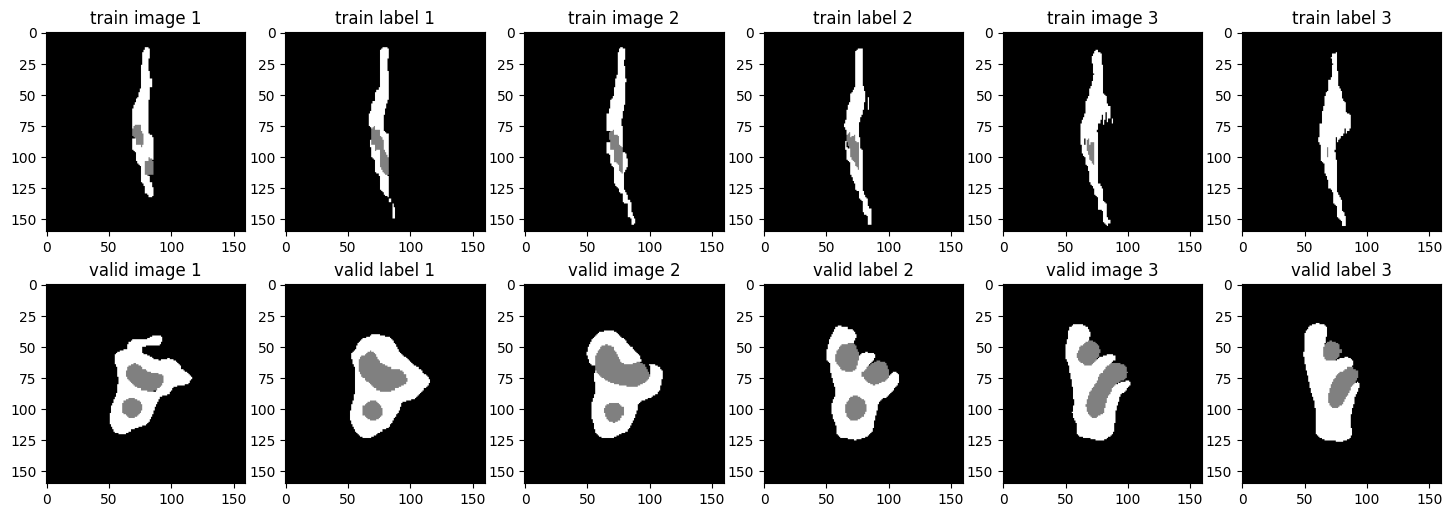

time: 2.16 s (started: 2024-02-03 15:42:44 +00:00)


In [ ]:
case_num = 70
slice_id = 12

train_image_name = os.path.split(train_ds[case_num]["image"].meta["filename_or_obj"])[1]
print("train image: ", train_image_name)
train_data = train_ds[case_num]
train_image, train_label = train_data["image"], train_data["label"]
train_image_shape = train_image.shape
print(f"train image shape: {train_image_shape}, train label : {train_label}")

valid_image_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
print("valid image: ", valid_image_name)
valid_data = val_ds[case_num]
valid_image, valid_label = valid_data["image"], valid_data["label"]
valid_image_shape = valid_image.shape
print(f"valid image shape: {valid_image_shape}, valid label : {valid_label}")

fig, ax = plt.subplots(2, 6, figsize=(18, 6))

ax[0,0].set_title("train image 1")
ax[0,0].imshow(train_image[0, :, :, slice_id   ].detach().cpu(), cmap="gray")
ax[0,1].set_title("train label 1")
ax[0,1].imshow(train_image[0, :, :, slice_id + 1].detach().cpu(), cmap="gray")
ax[0,2].set_title("train image 2")
ax[0,2].imshow(train_image[0, :, :, slice_id + 2].detach().cpu(), cmap="gray")
ax[0,3].set_title("train label 2")
ax[0,3].imshow(train_image[0, :, :, slice_id + 3].detach().cpu(), cmap="gray")
ax[0,4].set_title("train image 3")
ax[0,4].imshow(train_image[0, :, :, slice_id + 4].detach().cpu(), cmap="gray")
ax[0,5].set_title("train label 3")
ax[0,5].imshow(train_image[0, :, :, slice_id + 5].detach().cpu(), cmap="gray")

ax[1,0].set_title("valid image 1")
ax[1,0].imshow(valid_image[0, :, :, slice_id   ].detach().cpu(), cmap="gray")
ax[1,1].set_title("valid label 1")
ax[1,1].imshow(valid_image[0, :, :, slice_id + 1].detach().cpu(), cmap="gray")
ax[1,2].set_title("valid image 2")
ax[1,2].imshow(valid_image[0, :, :, slice_id + 2].detach().cpu(), cmap="gray")
ax[1,3].set_title("valid label 2")
ax[1,3].imshow(valid_image[0, :, :, slice_id + 3].detach().cpu(), cmap="gray")
ax[1,4].set_title("valid image 3")
ax[1,4].imshow(valid_image[0, :, :, slice_id + 4].detach().cpu(), cmap="gray")
ax[1,5].set_title("valid label 3")
ax[1,5].imshow(valid_image[0, :, :, slice_id + 5].detach().cpu(), cmap="gray")

In [ ]:
batch = 32
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=batch, shuffle=True)
val_loader  = ThreadDataLoader(val_ds,  num_workers=0, batch_size=batch)

time: 4.88 ms (started: 2024-02-03 15:42:46 +00:00)


In [ ]:
from ResNeXt3D.resnext3d import generate_model

# model_depth in [50, 101, 152, 200]
model = generate_model(152, n_input_channels=1, n_classes=1).to(device)

max_epoch = 200
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0005)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.99, weight_decay=0.0005, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_epoch, eta_min=0.00001, last_epoch=-1, verbose=True)
scaler = torch.cuda.amp.GradScaler()

loss_function = torch.nn.BCEWithLogitsLoss()
acc_metrics  = BinaryAccuracy(threshold=0.5)
torch.backends.cudnn.benchmark = True

Adjusting learning rate of group 0 to 1.0000e-03.
time: 4.5 s (started: 2024-02-03 15:42:46 +00:00)


In [ ]:
model_name = "ResNext3D_model_bymask_v4"
isValid_checkpoint = glob.glob(os.getcwd() + "/" + model_name + ".pth")

if isValid_checkpoint:
  checkpoint = torch.load(f"{model_name}.pth")
  # parameters
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
  scaler.load_state_dict(checkpoint["scaler"])
  # records
  last_epoch = checkpoint["last_epoch"]
  val_acc_best = checkpoint["best_acc"]
else:
  last_epoch = 0
  val_acc_best = 0

if val_acc_best != 0:
  print(f"Load model {model_name} success.")
else:
  print(f"Model is trained from scratch.")

print(f"Current best Acc is {val_acc_best}, last epoch is {last_epoch}, current learning rate is {lr_scheduler.get_last_lr()}.")

Model is trained from scratch.
Current best Acc is 0, last epoch is 0, current learning rate is [0.001].
time: 1.39 ms (started: 2024-02-03 15:42:50 +00:00)


In [ ]:
def validation(val_loader, val_iterations):
  model.eval()
  val_iterator = tqdm(val_loader, desc="Validate (X / X Steps)", dynamic_ncols=True)

  with torch.no_grad():
    for step, batch in enumerate(val_iterator):
      x, y = batch["image"].to(device), batch["label"].to(device)
      with torch.cuda.amp.autocast():
        preds = torch.squeeze(torch.sigmoid(model(x)), 1)

      acc_metrics.update(preds, y)

      # update procedure
      val_iterator.set_description(f"Validation ({step + 1} / {val_iterations} Steps)", refresh=True)

    mean_val_acc = acc_metrics.compute().item()
    acc_metrics.reset()
  return mean_val_acc

time: 600 µs (started: 2024-02-03 15:42:50 +00:00)


In [ ]:
def train(train_loader, global_step, max_iterations):
  model.train()
  train_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)

  acc_cnt = 0
  acc_loss = 0
  for batch in train_iterator:
    x, y = batch["image"].to(device), batch["label"].float().to(device)
    with torch.cuda.amp.autocast():
      scores = torch.squeeze(model(x), 1)
      loss  = loss_function(scores, y)

    acc_cnt += x.shape[0]
    acc_loss += loss.item() * x.shape[0]
    global_step += 1

    # gradient backprop
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad()

    # update procedure
    train_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss.item():2.5f})", refresh=True)

  train_loss_history.append(acc_loss / acc_cnt)
  return global_step

time: 677 µs (started: 2024-02-03 15:42:50 +00:00)


In [ ]:
tqdm = partial(tqdm, position=0, leave=True)

metric_values = []
train_loss_history = []

time: 487 µs (started: 2024-02-03 15:42:50 +00:00)


In [ ]:
# training constants
train_iterations = math.ceil(len(train_ds) / batch)
val_iterations  = math.ceil(len(val_ds)  / batch)
epoch = 200   # 100epoch 2h 5min
global_step = 0
max_iterations = epoch * train_iterations # (x epoch)
eval_num    = 1
save_every   = 20

# start training
for n in range(1, epoch + 1):
  global_step = train(train_loader, global_step, max_iterations)
  last_epoch += 1
  lr_scheduler.step()

  # validation
  if n % eval_num == 0 or n == epoch:
    val_acc = validation(val_loader, val_iterations)
    metric_values.append(val_acc)

    if val_acc_best == 0:
      # initilize best acc
      val_acc_best = val_acc
      print(f"First validation, Acc is {val_acc_best}.")

    elif val_acc >= val_acc_best:
      # update the best acc and save the best model checkpoint
      print(f"New Acc {val_acc} is better than previous best Acc {val_acc_best}")
      val_acc_best = val_acc
      torch.save({"model_state_dict": model.state_dict(),
            "best_acc": val_acc_best},
            f"{model_name}_best.pth")

    else:
      print(f"Current Acc {val_acc} is not better than the best Acc {val_acc_best}")

  if n % save_every == 0 or n == epoch:
    torch.save({"model_state_dict": model.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "best_acc": val_acc_best,
          "lr_scheduler": lr_scheduler.state_dict(),
          "last_epoch": last_epoch,
          "scaler": scaler.state_dict()},
          f"{model_name}.pth")

    train_loss_df = pd.DataFrame(train_loss_history, columns=["train_loss"])
    train_loss_df.to_csv(f"{model_name}_train_loss.csv", index=False)
    val_acc_df = pd.DataFrame(metric_values, columns=["val_acc"])
    val_acc_df.to_csv(f"{model_name}_val_acc.csv", index=False)

print(f"trained epoch {last_epoch}, best_metric: {val_acc_best:.4f}")

Training (24 / 4800 Steps) (loss=0.05754): 100%|██████████| 24/24 [01:28<00:00,  3.69s/it]


Adjusting learning rate of group 0 to 9.9994e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


First validation, Acc is 0.46560847759246826.


Training (48 / 4800 Steps) (loss=0.00026): 100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 9.9976e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


New Acc 0.8994709253311157 is better than previous best Acc 0.46560847759246826


Training (72 / 4800 Steps) (loss=0.00334): 100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 9.9945e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


New Acc 0.9735449552536011 is better than previous best Acc 0.8994709253311157


Training (96 / 4800 Steps) (loss=0.01356): 100%|██████████| 24/24 [00:45<00:00,  1.92s/it]


Adjusting learning rate of group 0 to 9.9902e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


New Acc 0.9841269850730896 is better than previous best Acc 0.9735449552536011


Training (120 / 4800 Steps) (loss=0.06784): 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 9.9847e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


New Acc 0.9841269850730896 is better than previous best Acc 0.9841269850730896


Training (144 / 4800 Steps) (loss=0.01344): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 9.9780e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


New Acc 0.9894179701805115 is better than previous best Acc 0.9841269850730896


Training (168 / 4800 Steps) (loss=0.00735): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 9.9701e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9894179701805115


Training (192 / 4800 Steps) (loss=0.00487): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 9.9610e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9894179701805115


Training (216 / 4800 Steps) (loss=0.00160): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 9.9506e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


New Acc 0.9894179701805115 is better than previous best Acc 0.9894179701805115


Training (240 / 4800 Steps) (loss=0.48011): 100%|██████████| 24/24 [00:46<00:00,  1.93s/it]


Adjusting learning rate of group 0 to 9.9391e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


New Acc 0.9894179701805115 is better than previous best Acc 0.9894179701805115


Training (264 / 4800 Steps) (loss=0.00097): 100%|██████████| 24/24 [00:46<00:00,  1.93s/it]


Adjusting learning rate of group 0 to 9.9263e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9894179701805115


Training (288 / 4800 Steps) (loss=0.00064): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 9.9123e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9894179701805115


Training (312 / 4800 Steps) (loss=0.00263): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 9.8972e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


New Acc 0.9894179701805115 is better than previous best Acc 0.9894179701805115


Training (336 / 4800 Steps) (loss=0.04744): 100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Adjusting learning rate of group 0 to 9.8808e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


New Acc 0.9894179701805115 is better than previous best Acc 0.9894179701805115


Training (360 / 4800 Steps) (loss=0.00160): 100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Adjusting learning rate of group 0 to 9.8632e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


New Acc 0.9894179701805115 is better than previous best Acc 0.9894179701805115


Training (384 / 4800 Steps) (loss=0.00356): 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 9.8445e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9894179701805115


Training (408 / 4800 Steps) (loss=0.03150): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 9.8246e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


New Acc 0.9894179701805115 is better than previous best Acc 0.9894179701805115


Training (432 / 4800 Steps) (loss=0.00388): 100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Adjusting learning rate of group 0 to 9.8035e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


New Acc 0.9894179701805115 is better than previous best Acc 0.9894179701805115


Training (456 / 4800 Steps) (loss=0.23074): 100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 9.7812e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9894179701805115


Training (480 / 4800 Steps) (loss=0.00077): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 9.7577e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


New Acc 0.9947090148925781 is better than previous best Acc 0.9894179701805115


Training (504 / 4800 Steps) (loss=0.00255): 100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


Adjusting learning rate of group 0 to 9.7331e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (528 / 4800 Steps) (loss=0.00194): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 9.7074e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (552 / 4800 Steps) (loss=0.00271): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 9.6804e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (576 / 4800 Steps) (loss=0.14284): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 9.6524e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Current Acc 0.9735449552536011 is not better than the best Acc 0.9947090148925781


Training (600 / 4800 Steps) (loss=0.13109): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 9.6232e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (624 / 4800 Steps) (loss=0.00417): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 9.5929e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (648 / 4800 Steps) (loss=0.00719): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 9.5614e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (672 / 4800 Steps) (loss=0.37262): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 9.5289e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (696 / 4800 Steps) (loss=0.00849): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 9.4952e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (720 / 4800 Steps) (loss=0.00163): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 9.4605e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (744 / 4800 Steps) (loss=0.00447): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 9.4246e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (768 / 4800 Steps) (loss=0.00055): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 9.3877e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (792 / 4800 Steps) (loss=0.00304): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 9.3497e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (816 / 4800 Steps) (loss=0.00761): 100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 9.3107e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (840 / 4800 Steps) (loss=0.00097): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 9.2706e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (864 / 4800 Steps) (loss=0.00397): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 9.2294e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (888 / 4800 Steps) (loss=0.00426): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 9.1872e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (912 / 4800 Steps) (loss=0.01589): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 9.1440e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


New Acc 0.9947090148925781 is better than previous best Acc 0.9947090148925781


Training (936 / 4800 Steps) (loss=0.04758): 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 9.0998e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (960 / 4800 Steps) (loss=0.05195): 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 9.0546e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (984 / 4800 Steps) (loss=0.00118): 100%|██████████| 24/24 [00:47<00:00,  1.98s/it]


Adjusting learning rate of group 0 to 9.0084e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1008 / 4800 Steps) (loss=0.00644): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 8.9613e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1032 / 4800 Steps) (loss=0.00340): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 8.9131e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1056 / 4800 Steps) (loss=0.00037): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 8.8640e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1080 / 4800 Steps) (loss=0.00461): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 8.8140e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1104 / 4800 Steps) (loss=0.00765): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 8.7630e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1128 / 4800 Steps) (loss=0.00491): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 8.7112e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1152 / 4800 Steps) (loss=0.00335): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 8.6584e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1176 / 4800 Steps) (loss=0.10118): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 8.6047e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1200 / 4800 Steps) (loss=0.01013): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 8.5502e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1224 / 4800 Steps) (loss=0.00472): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 8.4948e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1248 / 4800 Steps) (loss=0.00195): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 8.4385e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1272 / 4800 Steps) (loss=0.00635): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 8.3814e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1296 / 4800 Steps) (loss=0.00981): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 8.3235e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1320 / 4800 Steps) (loss=0.00811): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 8.2648e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1344 / 4800 Steps) (loss=0.02461): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 8.2052e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1368 / 4800 Steps) (loss=0.00013): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 8.1450e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1392 / 4800 Steps) (loss=0.00901): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 8.0839e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1416 / 4800 Steps) (loss=0.01930): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 8.0221e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1440 / 4800 Steps) (loss=0.00244): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 7.9595e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1464 / 4800 Steps) (loss=0.00376): 100%|██████████| 24/24 [00:47<00:00,  1.98s/it]


Adjusting learning rate of group 0 to 7.8963e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1488 / 4800 Steps) (loss=0.00133): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 7.8323e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1512 / 4800 Steps) (loss=0.00364): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 7.7677e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1536 / 4800 Steps) (loss=0.00162): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 7.7023e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1560 / 4800 Steps) (loss=0.00068): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 7.6364e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1584 / 4800 Steps) (loss=0.08677): 100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 7.5698e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1608 / 4800 Steps) (loss=0.00034): 100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 7.5025e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1632 / 4800 Steps) (loss=0.00146): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 7.4347e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1656 / 4800 Steps) (loss=0.00045): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 7.3663e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1680 / 4800 Steps) (loss=0.00062): 100%|██████████| 24/24 [00:43<00:00,  1.83s/it]


Adjusting learning rate of group 0 to 7.2973e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1704 / 4800 Steps) (loss=0.00213): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 7.2277e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1728 / 4800 Steps) (loss=0.00033): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 7.1576e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1752 / 4800 Steps) (loss=0.00219): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 7.0870e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1776 / 4800 Steps) (loss=0.00081): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 7.0159e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1800 / 4800 Steps) (loss=0.00331): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 6.9443e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1824 / 4800 Steps) (loss=0.13810): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 6.8722e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1848 / 4800 Steps) (loss=0.00164): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 6.7997e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1872 / 4800 Steps) (loss=0.00453): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 6.7268e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1896 / 4800 Steps) (loss=0.01558): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 6.6534e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1920 / 4800 Steps) (loss=0.00257): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 6.5796e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1944 / 4800 Steps) (loss=0.08460): 100%|██████████| 24/24 [00:47<00:00,  1.98s/it]


Adjusting learning rate of group 0 to 6.5055e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (1968 / 4800 Steps) (loss=0.00376): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 6.4310e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (1992 / 4800 Steps) (loss=0.00270): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 6.3562e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2016 / 4800 Steps) (loss=0.00056): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 6.2810e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (2040 / 4800 Steps) (loss=0.00988): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 6.2056e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2064 / 4800 Steps) (loss=0.00404): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 6.1298e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2088 / 4800 Steps) (loss=0.01280): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 6.0538e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (2112 / 4800 Steps) (loss=0.00010): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 5.9775e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2136 / 4800 Steps) (loss=0.00360): 100%|██████████| 24/24 [00:43<00:00,  1.83s/it]


Adjusting learning rate of group 0 to 5.9010e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (2160 / 4800 Steps) (loss=0.00400): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 5.8244e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2184 / 4800 Steps) (loss=0.00192): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 5.7475e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2208 / 4800 Steps) (loss=0.00247): 100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 5.6704e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2232 / 4800 Steps) (loss=0.00104): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 5.5932e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (2256 / 4800 Steps) (loss=0.07903): 100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Adjusting learning rate of group 0 to 5.5158e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (2280 / 4800 Steps) (loss=0.00295): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 5.4384e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (2304 / 4800 Steps) (loss=0.15037): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 5.3608e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2328 / 4800 Steps) (loss=0.00123): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 5.2832e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (2352 / 4800 Steps) (loss=0.00388): 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 5.2055e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2376 / 4800 Steps) (loss=0.00071): 100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 5.1278e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2400 / 4800 Steps) (loss=0.00442): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 5.0500e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2424 / 4800 Steps) (loss=0.02968): 100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


Adjusting learning rate of group 0 to 4.9722e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2448 / 4800 Steps) (loss=0.00414): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 4.8945e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (2472 / 4800 Steps) (loss=0.00059): 100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 4.8168e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2496 / 4800 Steps) (loss=0.11208): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 4.7392e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2520 / 4800 Steps) (loss=0.00583): 100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 4.6616e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2544 / 4800 Steps) (loss=0.00415): 100%|██████████| 24/24 [00:43<00:00,  1.83s/it]


Adjusting learning rate of group 0 to 4.5842e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2568 / 4800 Steps) (loss=0.00135): 100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 4.5068e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (2592 / 4800 Steps) (loss=0.15925): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 4.4296e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2616 / 4800 Steps) (loss=0.00210): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 4.3525e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2640 / 4800 Steps) (loss=0.00204): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 4.2756e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2664 / 4800 Steps) (loss=0.00075): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 4.1990e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2688 / 4800 Steps) (loss=0.00252): 100%|██████████| 24/24 [00:43<00:00,  1.81s/it]


Adjusting learning rate of group 0 to 4.1225e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (2712 / 4800 Steps) (loss=0.00017): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 4.0462e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2736 / 4800 Steps) (loss=0.00101): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 3.9702e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2760 / 4800 Steps) (loss=0.00045): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 3.8944e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2784 / 4800 Steps) (loss=0.00221): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 3.8190e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2808 / 4800 Steps) (loss=0.00001): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 3.7438e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (2832 / 4800 Steps) (loss=0.00001): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 3.6690e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2856 / 4800 Steps) (loss=0.00499): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 3.5945e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2880 / 4800 Steps) (loss=0.00317): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 3.5204e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (2904 / 4800 Steps) (loss=0.00740): 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Adjusting learning rate of group 0 to 3.4466e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (2928 / 4800 Steps) (loss=0.00027): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 3.3732e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (2952 / 4800 Steps) (loss=0.00082): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 3.3003e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (2976 / 4800 Steps) (loss=0.00026): 100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 3.2278e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3000 / 4800 Steps) (loss=0.01300): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 3.1557e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3024 / 4800 Steps) (loss=0.00056): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 3.0841e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (3048 / 4800 Steps) (loss=0.05913): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 3.0130e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (3072 / 4800 Steps) (loss=0.04025): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 2.9424e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (3096 / 4800 Steps) (loss=0.00351): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 2.8723e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3120 / 4800 Steps) (loss=0.07273): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 2.8027e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3144 / 4800 Steps) (loss=0.00033): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 2.7337e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3168 / 4800 Steps) (loss=0.00328): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 2.6653e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3192 / 4800 Steps) (loss=0.07584): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 2.5975e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3216 / 4800 Steps) (loss=0.00072): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 2.5302e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3240 / 4800 Steps) (loss=0.00004): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 2.4636e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (3264 / 4800 Steps) (loss=0.10029): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 2.3977e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (3288 / 4800 Steps) (loss=0.00050): 100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 2.3323e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3312 / 4800 Steps) (loss=0.00013): 100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 2.2677e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3336 / 4800 Steps) (loss=0.00145): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 2.2037e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3360 / 4800 Steps) (loss=0.01484): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 2.1405e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Current Acc 0.9682539701461792 is not better than the best Acc 0.9947090148925781


Training (3384 / 4800 Steps) (loss=0.00411): 100%|██████████| 24/24 [00:47<00:00,  1.99s/it]


Adjusting learning rate of group 0 to 2.0779e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3408 / 4800 Steps) (loss=0.00096): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 2.0161e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (3432 / 4800 Steps) (loss=0.00144): 100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 1.9550e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3456 / 4800 Steps) (loss=0.00261): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 1.8948e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9735449552536011 is not better than the best Acc 0.9947090148925781


Training (3480 / 4800 Steps) (loss=0.00070): 100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


Adjusting learning rate of group 0 to 1.8352e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3504 / 4800 Steps) (loss=0.00001): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 1.7765e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (3528 / 4800 Steps) (loss=0.00226): 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 1.7186e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3552 / 4800 Steps) (loss=0.00305): 100%|██████████| 24/24 [00:46<00:00,  1.93s/it]


Adjusting learning rate of group 0 to 1.6615e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (3576 / 4800 Steps) (loss=0.00031): 100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 1.6052e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3600 / 4800 Steps) (loss=0.00045): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 1.5498e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3624 / 4800 Steps) (loss=0.00081): 100%|██████████| 24/24 [00:46<00:00,  1.92s/it]


Adjusting learning rate of group 0 to 1.4953e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


Current Acc 0.9682539701461792 is not better than the best Acc 0.9947090148925781


Training (3648 / 4800 Steps) (loss=0.01939): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 1.4416e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (3672 / 4800 Steps) (loss=0.04647): 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 1.3888e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (3696 / 4800 Steps) (loss=0.00174): 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 1.3370e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3720 / 4800 Steps) (loss=0.00064): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 1.2860e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (3744 / 4800 Steps) (loss=0.00075): 100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 1.2360e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9682539701461792 is not better than the best Acc 0.9947090148925781


Training (3768 / 4800 Steps) (loss=0.00598): 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 1.1869e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (3792 / 4800 Steps) (loss=0.00008): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 1.1387e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Current Acc 0.9735449552536011 is not better than the best Acc 0.9947090148925781


Training (3816 / 4800 Steps) (loss=0.00501): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 1.0916e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (3840 / 4800 Steps) (loss=0.00087): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 1.0454e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3864 / 4800 Steps) (loss=0.00183): 100%|██████████| 24/24 [00:48<00:00,  2.03s/it]


Adjusting learning rate of group 0 to 1.0002e-04.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3888 / 4800 Steps) (loss=0.00120): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 9.5595e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9682539701461792 is not better than the best Acc 0.9947090148925781


Training (3912 / 4800 Steps) (loss=0.00085): 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 9.1275e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3936 / 4800 Steps) (loss=0.00026): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 8.7058e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3960 / 4800 Steps) (loss=0.00045): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 8.2943e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (3984 / 4800 Steps) (loss=0.00574): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 7.8933e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4008 / 4800 Steps) (loss=0.00135): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 7.5027e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4032 / 4800 Steps) (loss=0.00001): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 7.1228e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4056 / 4800 Steps) (loss=0.00023): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 6.7536e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4080 / 4800 Steps) (loss=0.00017): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 6.3952e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4104 / 4800 Steps) (loss=0.00012): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 6.0476e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4128 / 4800 Steps) (loss=0.00025): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 5.7111e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4152 / 4800 Steps) (loss=0.00001): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 5.3855e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4176 / 4800 Steps) (loss=0.01571): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 5.0711e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4200 / 4800 Steps) (loss=0.00025): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 4.7680e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4224 / 4800 Steps) (loss=0.00053): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 4.4761e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


New Acc 0.9947090148925781 is better than previous best Acc 0.9947090148925781


Training (4248 / 4800 Steps) (loss=0.00007): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 4.1955e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4272 / 4800 Steps) (loss=0.00063): 100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 3.9264e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4296 / 4800 Steps) (loss=0.00022): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 3.6688e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (4320 / 4800 Steps) (loss=0.00108): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 3.4227e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4344 / 4800 Steps) (loss=0.00012): 100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


Adjusting learning rate of group 0 to 3.1882e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4368 / 4800 Steps) (loss=0.00320): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 2.9655e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (4392 / 4800 Steps) (loss=0.00003): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 2.7544e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9894179701805115 is not better than the best Acc 0.9947090148925781


Training (4416 / 4800 Steps) (loss=0.00002): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 2.5551e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4440 / 4800 Steps) (loss=0.00038): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 2.3677e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4464 / 4800 Steps) (loss=0.00002): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 2.1921e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4488 / 4800 Steps) (loss=0.00019): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 2.0285e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4512 / 4800 Steps) (loss=0.00003): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 1.8768e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4536 / 4800 Steps) (loss=0.00003): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 1.7371e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4560 / 4800 Steps) (loss=0.00014): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 1.6094e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4584 / 4800 Steps) (loss=0.00068): 100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Adjusting learning rate of group 0 to 1.4938e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4608 / 4800 Steps) (loss=0.00454): 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Adjusting learning rate of group 0 to 1.3903e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4632 / 4800 Steps) (loss=0.00011): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 1.2989e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4656 / 4800 Steps) (loss=0.00002): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 1.2197e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4680 / 4800 Steps) (loss=0.00002): 100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


Adjusting learning rate of group 0 to 1.1526e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4704 / 4800 Steps) (loss=0.00007): 100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Adjusting learning rate of group 0 to 1.0977e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4728 / 4800 Steps) (loss=0.00031): 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 1.0550e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4752 / 4800 Steps) (loss=0.06962): 100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


Adjusting learning rate of group 0 to 1.0244e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Current Acc 0.9841269850730896 is not better than the best Acc 0.9947090148925781


Training (4776 / 4800 Steps) (loss=0.00023): 100%|██████████| 24/24 [00:45<00:00,  1.88s/it]


Adjusting learning rate of group 0 to 1.0061e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781


Training (4800 / 4800 Steps) (loss=0.00008): 100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Adjusting learning rate of group 0 to 1.0000e-05.


Validation (6 / 6 Steps): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Current Acc 0.9788359999656677 is not better than the best Acc 0.9947090148925781
trained epoch 200, best_metric: 0.9947
time: 2h 49min 7s (started: 2024-02-03 15:44:07 +00:00)
